# Models for nuclear interactions on neutron stars

In this notebook, two models are built in order to consider the nuclear interactions on dense matter of neutron stars. The first model is parametrized with empirical interactions. The second is made using Skyrme parametrization. The EoS for both models are used to resolve the TOV equation and find the mass-radius relation. This project follows [Compact Stars For Undergraduates](https://arxiv.org/pdf/astro-ph/0506417).

First, importing necessary libraries, methods and constants:

In [11]:
from scipy.constants import atomic_mass, e, m_p, m_n, pi, G, hbar, c, m_e
from astropy.constants import M_sun
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from tov import mass_radius, dm_dr_tov, dp_dr_tov
from empirical_nuclear_interactions import e_n_assymetric, p_n_assymetric, n0
from ns_with_protons_and_electrons import root_kn, kp_kn, total_pressure_density, total_energy_density
import math

## Tolman-Oppenheimer-Volkov equations

TOV hidrostatic equilibrium equations are defined as follows:

$$
\frac{dp}{dr} = -\frac{G\epsilon(r)m(r)}{c^2\,r^2} 
\left[ 1 + \frac{p(r)}{\epsilon(r)} \right]
\left[ 1 + \frac{4\pi r^3p(r)}{m(r)c^2} \right]
\left[ 1 -  \frac{2Gm(r)}{c^2\, r} \right]^{-1}$$
$$
\frac{dm}{dr} = \frac{4\pi r^2 \epsilon(r)}{c^2}.
$$

The equations above are resolved using Runge-Kutta 4 method to find the mass-radius relation.

## Empirical interaction


### Equations

Empirical interaction energy density:

$$\epsilon(n, \alpha)= n\left[ m_N + \langle E_0 \rangle u^{2/3} + \frac{A}{2}u + \frac{B}{\sigma +1}u^\sigma + (2^{2/3}-1)\langle E_0 \rangle \left(u^{2/3} -F(u) \right)\alpha^2 +  S_0F(u)\alpha^2 \right]$$

Empirical interaction pressure density:

$$
p(n, \alpha) = n_0 \left[\frac{2}{3} \langle E_0 \rangle  u^ {2/3} + \frac{A}{2}u^{2} + \frac{B\sigma u^{\sigma+1}}{\sigma+1} + \left[(2^{2/3}-1)\langle E_0 \rangle \left(u^{2/3} -F(u) \right)+  S_0F(u)\right]\alpha^2\right]
$$

Computing model:  TOV
10 % finished
20 % finished


/mnt/502AAAC52AAAA804/Dev/neutron-stars-mass-radius/tov.py:15: RuntimeWarning: invalid value encountered in divide
  t1 = (1 + (p_r_/e_r_))
/mnt/502AAAC52AAAA804/Dev/neutron-stars-mass-radius/tov.py:16: RuntimeWarning: invalid value encountered in scalar divide
  t2 = 1+ (4*pi*(r_**3)*p_r_)/(m_r_*(c**2))


30 % finished
40 % finished
50 % finished
60 % finished
70 % finished
80 % finished
90 % finished
100 % finished
Finished for  TOV


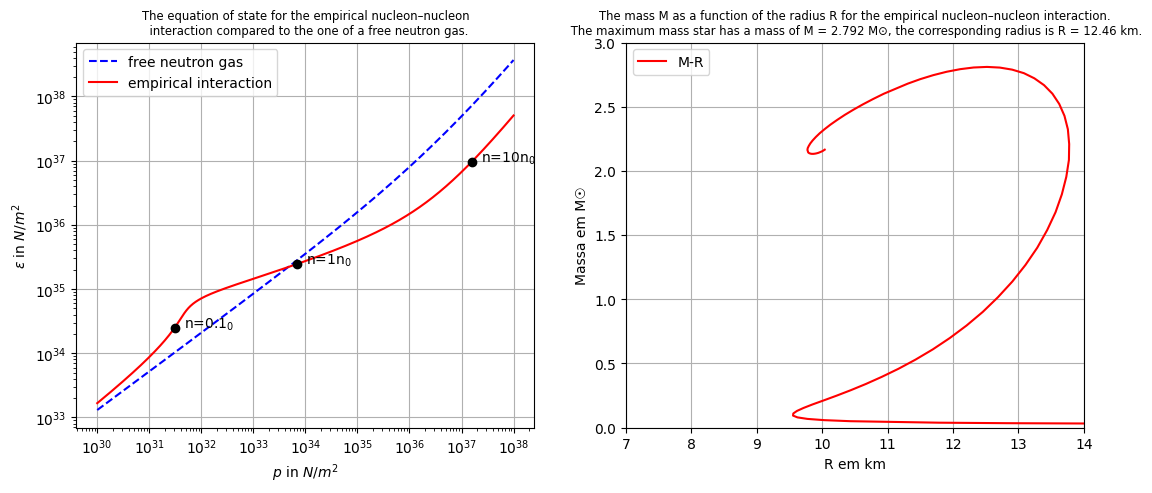

In [12]:
#encontrando os valores de pressão e densidade de energia para um modelo sem neutrons
p_free_neutron = np.logspace(np.log10(1e29), np.log10(1e37), 130)

kn_free_neutron =[]

for p in p_free_neutron:
  kn_free_neutron.append(root_kn(p))

p_total_free_neutron = [total_pressure_density(kn, kp_kn(kn)) for kn in kn_free_neutron]
e_total_free_neutron = [total_energy_density(kn, kp_kn(kn)) for kn in kn_free_neutron]

#transformando para as unidades do artigo
p_total_array = np.array(p_total_free_neutron)
p_total_array*=10
e_total_array = np.array(e_total_free_neutron)
e_total_array*=10

#encontrando os valores de pressão e densidade de energia para um modelo com interação nucleon-nucleon
start_n = n0*1e-22
end_n = n0*5e2

n_array = np.logspace(np.log10(start_n), np.log10(end_n), 1000)

p_correc = []
e_correc = []

n_marksx = ['','','']
n_marksy = ['','','']

for n in n_array:
  p_result = p_n_assymetric(n,1)
  e_result = e_n_assymetric(n,1)

  p_correc.append(p_result)
  e_correc.append(e_result)

  if n_marksx[0]=='' and n>=0.1*n0:
    n_marksx[0]=[p_result*10]
    n_marksy[0]=[e_result*10]
  if n_marksx[1]=='' and n>=n0:
    n_marksx[1]=[p_result*10]
    n_marksy[1]=[e_result*10]
  if n_marksx[2]=='' and n>=10*n0:
    n_marksx[2]=[p_result*10]
    n_marksy[2]=[e_result*10]

p_correc = np.array(p_correc)
e_correc = np.array(e_correc)

#spline com valores de pxe no SI
cs_pxe_dyne = CubicSpline(p_correc, e_correc)

p_correc*=10
e_correc*=10

#spline com valores de pxe sendo dyne/cm²
cs_pxe_si = CubicSpline(p_correc, e_correc)

#encontrando os valores de pressão, massa e raio no intervalo 1e30<=p<=1e38
p_mr, m_mr, r_mr = mass_radius(gdm = dm_dr_tov, gdp = dp_dr_tov, m0_ = 1e-5, spline = cs_pxe_dyne, r_fim_=20000,ps_ini=1e30,ps_fim=1e38, modelo="TOV")

#dividindo pela massa do sol
m_mr = np.array(m_mr)
m_mr/=M_sun.value

#metro para km
r_mr = np.array(r_mr)
r_mr/=1000

#printando os gráficos
p_total_nucleon = np.logspace(np.log10(1e30), np.log10(1e38), 1000)

fig, ax1 = plt.subplots(1,2, figsize=(13,5))

ax1[0].set_xlabel(r"$p$ in $N/m^2$")
ax1[0].set_ylabel(r"$\epsilon$ in $N/m^2$")
ax1[0].plot(p_total_array, e_total_array, color="blue", linestyle='dashed',label="free neutron gas")
ax1[0].plot(p_total_nucleon, cs_pxe_si(p_total_nucleon), color="red", label="empirical interaction")
ax1[0].scatter(n_marksx, n_marksy, color='black',zorder=3)
ax1[0].annotate('n=0.1$_0$', xy=(n_marksx[0][0], n_marksy[0][0]), xytext = (n_marksx[0][0]*1.5, n_marksy[0][0]))
ax1[0].annotate('n=1n$_0$', xy=(n_marksx[1][0], n_marksy[1][0]), xytext = (n_marksx[1][0]*1.5, n_marksy[1][0]))
ax1[0].annotate('n=10n$_0$', xy=(n_marksx[2][0],n_marksy[2][0]), xytext = (n_marksx[2][0]*1.5, n_marksy[2][0]))
ax1[0].tick_params(axis='y')
ax1[0].set_title("""The equation of state for the empirical nucleon–nucleon
  interaction compared to the one of a free neutron gas.""", fontsize="small")
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].legend()
ax1[0].grid()

ax1[1].set_xlabel('R em km')
ax1[1].set_xlim(7,14)
ax1[1].set_ylim(0,3)
ax1[1].set_ylabel('Massa em M\u2609')
ax1[1].plot(r_mr, m_mr, label='M-R', color='red')
ax1[1].grid()
ax1[1].set_title("""The mass M as a function of the radius R for the empirical nucleon–nucleon interaction.
 The maximum mass star has a mass of M = 2.792 M⊙, the corresponding radius is R = 12.46 km.""", fontsize='small')
ax1[1].legend()

plt.show()